In [1]:
# 1. Load reduced dataset
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/reduced_heart_disease.csv")

# Convert target into binary: 0 = no disease, 1 = disease
y = (df["target"] > 0).astype(int)
X = df.drop("target", axis=1)

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# 2. Train 4 models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, random_state=42)  
}

# Fit models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"✅ {name} trained")

✅ Logistic Regression trained
✅ Decision Tree trained
✅ Random Forest trained
✅ SVM trained


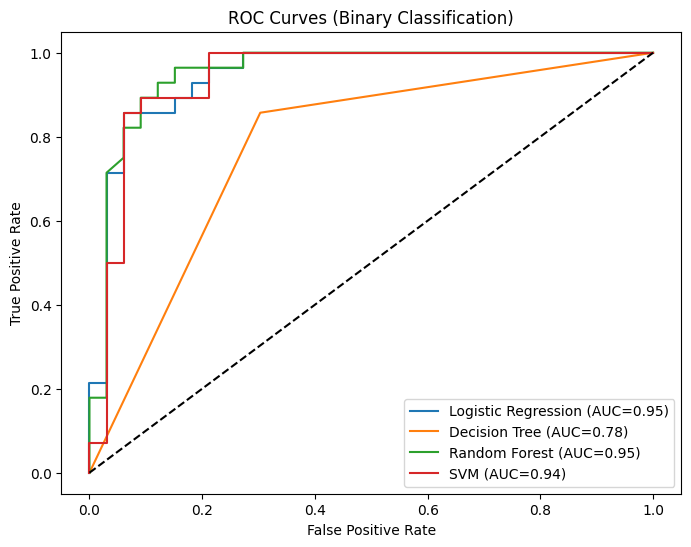

In [ ]:
# 3. Evaluate models (Accuracy, Precision, Recall, F1, AUC + ROC curve)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

results = []

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]  
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    results.append([name, acc, prec, rec, f1, auc])
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'k--')  # diagonal = random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Binary Classification)")
plt.legend()
plt.show()

In [4]:
# 4. Show results in a table
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"]
)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1-score       AUC
0  Logistic Regression  0.852459   0.806452  0.892857  0.847458  0.946970
1        Decision Tree  0.770492   0.705882  0.857143  0.774194  0.777056
2        Random Forest  0.901639   0.892857  0.892857  0.892857  0.951840
3                  SVM  0.868852   0.833333  0.892857  0.862069  0.939394


# Step 6 Hyperparameter tunning

In [5]:
from sklearn.model_selection import GridSearchCV

In [6]:
rf = RandomForestClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)

In [7]:
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10]
}

svm_params = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

In [8]:
grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring="accuracy")
grid_rf.fit(X_train, y_train)

grid_svm = GridSearchCV(svm, svm_params, cv=5, scoring="accuracy")
grid_svm.fit(X_train, y_train)

,estimator,SVC(probabili...ndom_state=42)
,param_grid,"{'C': [0.1, 1, ...], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [9]:
# RandomizedSearchCV for RF and SVM

from sklearn.model_selection import RandomizedSearchCV

rand_rf = RandomizedSearchCV(rf, rf_params, cv=5, scoring="accuracy", n_iter=5, random_state=42)
rand_rf.fit(X_train, y_train)

rand_svm = RandomizedSearchCV(svm, svm_params, cv=5, scoring="accuracy", n_iter=5, random_state=42)
rand_svm.fit(X_train, y_train)

print("Randomized RF Best Params:", rand_rf.best_params_)
print("Randomized RF Score:", rand_rf.best_score_)

print("Randomized SVM Best Params:", rand_svm.best_params_)
print("Randomized SVM Score:", rand_svm.best_score_)


Randomized RF Best Params: {'n_estimators': 100, 'max_depth': None}
Randomized RF Score: 0.8343537414965987
Randomized SVM Best Params: {'kernel': 'linear', 'gamma': 'auto', 'C': 10}
Randomized SVM Score: 0.8385204081632655


In [10]:
print("Best RF Params:", grid_rf.best_params_)
print("Best RF Score:", grid_rf.best_score_)

print("Best SVM Params:", grid_svm.best_params_)
print("Best SVM Score:", grid_svm.best_score_)

Best RF Params: {'max_depth': None, 'n_estimators': 100}
Best RF Score: 0.8343537414965987
Best SVM Params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM Score: 0.8385204081632655


# Comparing models after tunning 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#  Get best models from GridSearch 
best_rf = grid_rf.best_estimator_
best_svm = grid_svm.best_estimator_

#  Get best models from RandomizedSearch
best_rand_rf = rand_rf.best_estimator_
best_rand_svm = rand_svm.best_estimator_

def evaluate_model(name, model, X_test, y_test):
    """Helper function to compute all metrics for a model"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="binary")
    rec = recall_score(y_test, y_pred, average="binary")
    f1 = f1_score(y_test, y_pred, average="binary")
    auc = roc_auc_score(y_test, y_proba)
    
    return [name, acc, prec, rec, f1, auc]

# Evaluate tuned models 
results.extend([
    evaluate_model("Tuned RF (GridSearch)", best_rf, X_test, y_test),
    evaluate_model("Tuned SVM (GridSearch)", best_svm, X_test, y_test),
    evaluate_model("Tuned RF (RandomSearch)", best_rand_rf, X_test, y_test),
    evaluate_model("Tuned SVM (RandomSearch)", best_rand_svm, X_test, y_test)
])

# --- Show final comparison table ---
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"])
print(results_df.round(3))

                      Model  Accuracy  Precision  Recall  F1-score    AUC
0       Logistic Regression     0.852      0.806   0.893     0.847  0.947
1             Decision Tree     0.770      0.706   0.857     0.774  0.777
2             Random Forest     0.902      0.893   0.893     0.893  0.952
3                       SVM     0.869      0.833   0.893     0.862  0.939
4     Tuned RF (GridSearch)     0.885      0.862   0.893     0.877  0.946
5    Tuned SVM (GridSearch)     0.869      0.833   0.893     0.862  0.948
6   Tuned RF (RandomSearch)     0.885      0.862   0.893     0.877  0.946
7  Tuned SVM (RandomSearch)     0.869      0.833   0.893     0.862  0.948


# Conclusion: The default Random Forest remains the best-performing model, confirming that hyperparameter tuning was not necessary for this dataset (small) but helped validate the reliability of the chosen model.